# Real and Fake Face Detection

### datset folder can be found here
### https://drive.google.com/drive/folders/1rm4Y5KmLp6yrCHRREzuRfoXbR-0KlfwP?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import PIL
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import shutil

In [ ]:
### use only 1000 images
images_to_use = 1000
images_to_use_dir = "/content/drive/MyDrive/FaceDetect/Images_to_use/"
fake_faces = os.listdir(images_to_use_dir + 'fake')
real_faces = os.listdir(images_to_use_dir + 'real')
if (len(fake_faces) != 500 and len(real_faces) != 500):
  try:
    os.mkdir('/content/drive/MyDrive/FaceDetect/fake')
    os.mkdir('/content/drive/MyDrive/FaceDetect/real')
  except FileExistsError:
    pass

  for i in range(images_to_use//2, len(fake_faces)):
    shutil.move(images_to_use_dir + 'fake/' + fake_faces[i], '/content/drive/MyDrive/FaceDetect/fake/' + fake_faces[i] )
  for i in range(images_to_use//2, len(real_faces)):
    shutil.move(images_to_use_dir + 'real/' + real_faces[i], '/content/drive/MyDrive/FaceDetect/real/' + real_faces[i] )



In [ ]:
img_height = 600
img_width = 600

img_dir = '/content/drive/MyDrive/FaceDetect/Images_to_use'
train_data = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
)

valid_data = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
)


Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [ ]:
## check labels
train_data.class_names

['fake', 'real']

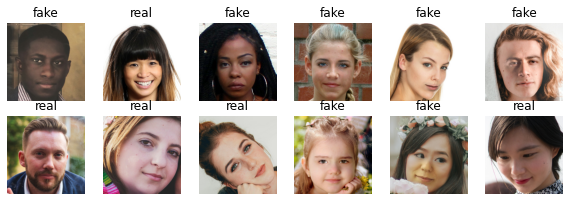

In [ ]:
class_labels = train_data.class_names
plt.figure(figsize=(10, 10))
for myimages, mylabels in train_data.take(1):
  for i in range(12):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(myimages[i].numpy().astype("uint8"))
    plt.title(class_labels[mylabels[i]])
    plt.axis("off")

In [ ]:
## check the size of image
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 600, 600, 3)
(32,)


# using 1 (C+P) layer (basic)

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])


In [ ]:
epochs_ = 10
face_output = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 115s 3s/step - loss: 199.9150 - binary_accuracy: 0.4712 - precision: 0.4885 - recall: 0.5133 - val_loss: 0.6952 - val_binary_accuracy: 0.4350 - val_precision: 0.4350 - val_recall: 1.0000
Epoch 2/10
25/25 [==============================] - 24s 886ms/step - loss: 0.6924 - binary_accuracy: 0.5175 - precision: 0.5169 - recall: 1.0000 - val_loss: 0.6977 - val_binary_accuracy: 0.4350 - val_precision: 0.4350 - val_recall: 1.0000
Epoch 3/10
25/25 [==============================] - 24s 878ms/step - loss: 0.6927 - binary_accuracy: 0.5163 - precision: 0.5163 - recall: 1.0000 - val_loss: 0.6985 - val_binary_accuracy: 0.4350 - val_precision: 0.4350 - val_recall: 1.0000
Epoch 4/10
25/25 [==============================] - 24s 889ms/step - loss: 0.6927 - binary_accuracy: 0.5163 - precision: 0.5163 - recall: 1.0000 - val_loss: 0.6987 - val_binary_accuracy: 0.4350 - val_precision: 0.4350 - val_recall: 1.0000
Epoch 5/10
25/25 [==========================

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision"]
  valid_precision = face_output.history["val_precision"]

  recall = face_output.history["recall"]
  valid_recall = face_output.history["val_recall"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}



In [ ]:
def visualize_results(face_output):

  results = gather_results(face_output)
    
  num_epochs = range(epochs_)
  plt.figure(figsize=(20,8))
  plt.subplot(1, 4, 1)
  plt.plot(num_epochs, results["accuracy"][0], label='Training Accuracy')
  plt.plot(num_epochs, results["accuracy"][1], label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  
  plt.subplot(1, 4, 2)
  plt.plot(num_epochs, results['loss'][0], label='Training Loss')
  plt.plot(num_epochs, results['loss'][1], label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  
  plt.subplot(1, 4, 3)
  plt.plot(num_epochs, results['precision'][0], label='Training precision')
  plt.plot(num_epochs, results['precision'][1], label='Validation precision')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Precision')
  
  plt.subplot(1, 4, 4)
  plt.plot(num_epochs, results['recall'][0], label='Training recall')
  plt.plot(num_epochs, results['recall'][1], label='Validation recall')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Recall')
  
  plt.show()

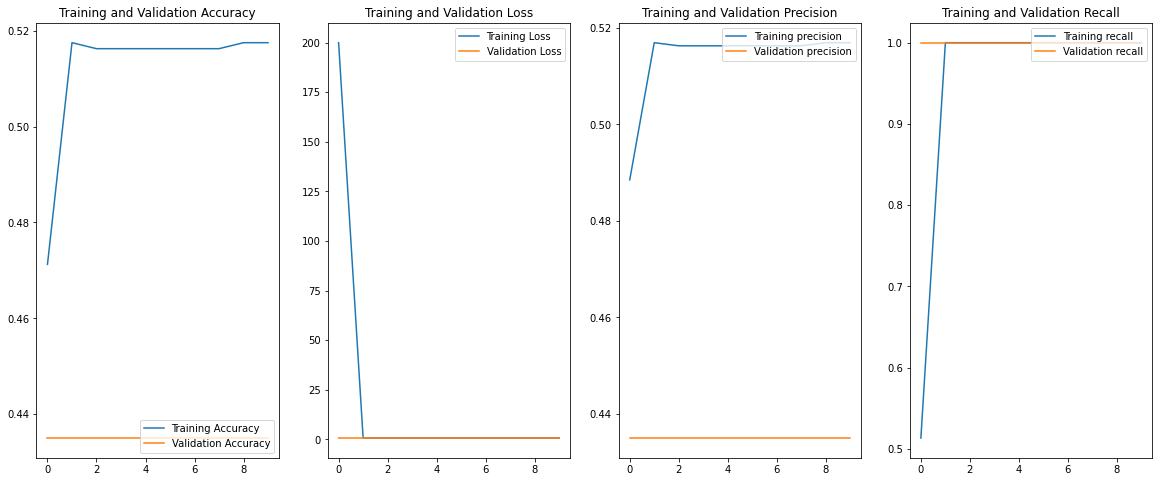

In [ ]:
visualize_results(face_output)

# 2 (C+P) layers

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(filters=16, kernel_size =(3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output2 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 19s 585ms/step - loss: 7.1553 - binary_accuracy: 0.5300 - precision_1: 0.5305 - recall_1: 0.7797 - val_loss: 0.6994 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 2/10
25/25 [==============================] - 16s 556ms/step - loss: 0.6930 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 1.0000 - val_loss: 0.6968 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 3/10
25/25 [==============================] - 16s 554ms/step - loss: 0.6927 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 1.0000 - val_loss: 0.6990 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 4/10
25/25 [==============================] - 16s 559ms/step - loss: 0.6930 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 1.0000 - val_loss: 0.6969 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 5/10
2

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision_1"]
  valid_precision = face_output.history["val_precision_1"]

  recall = face_output.history["recall_1"]
  valid_recall = face_output.history["val_recall_1"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}


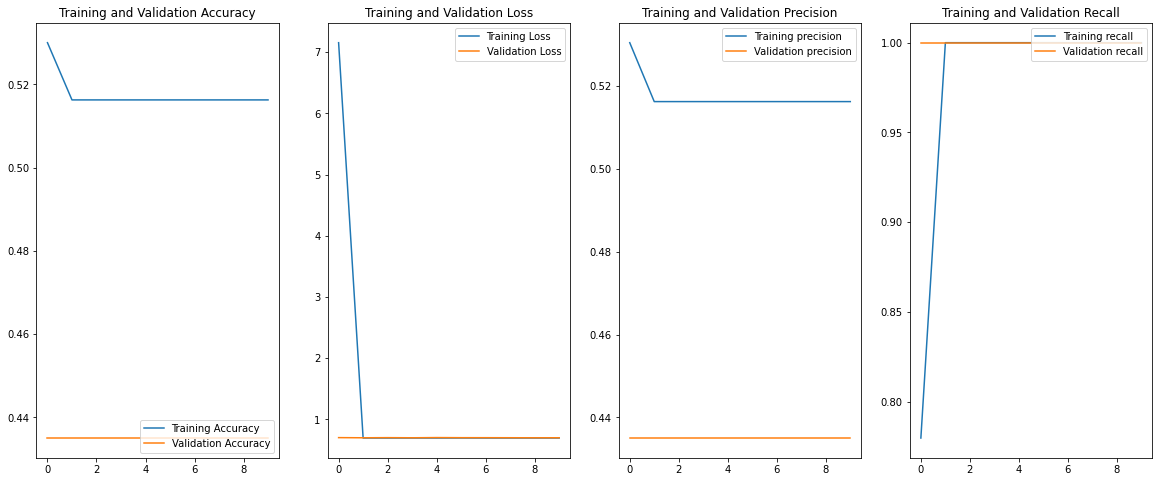

In [ ]:
epochs_=10
visualize_results(face_output2)

### There was no noticeable change in the accuracy, precision or recall after adding another convolution and pooling layer.

# add and remove dropout

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output3 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 27s 936ms/step - loss: 371.1456 - binary_accuracy: 0.4712 - precision_2: 0.4747 - recall_2: 0.2276 - val_loss: 0.6911 - val_binary_accuracy: 0.5650 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 25s 917ms/step - loss: 0.6933 - binary_accuracy: 0.4837 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6932 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4350 - val_recall_2: 1.0000
Epoch 3/10
25/25 [==============================] - 26s 936ms/step - loss: 0.6926 - binary_accuracy: 0.5188 - precision_2: 0.5175 - recall_2: 1.0000 - val_loss: 0.6971 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4350 - val_recall_2: 1.0000
Epoch 4/10
25/25 [==============================] - 26s 965ms/step - loss: 0.6927 - binary_accuracy: 0.5175 - precision_2: 0.5169 - recall_2: 1.0000 - val_loss: 0.6972 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4350 - val_recall_2: 1

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision_2"]
  valid_precision = face_output.history["val_precision_2"]

  recall = face_output.history["recall_2"]
  valid_recall = face_output.history["val_recall_2"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}

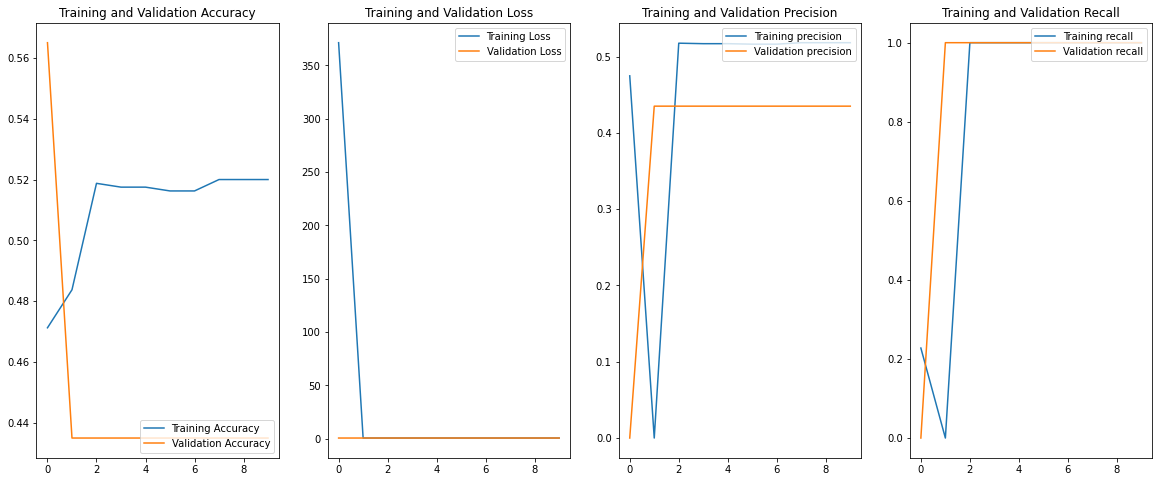

In [ ]:
visualize_results(face_output3)

### Adding a droput layer resulted in a minor increase in precision and no change in recall.

# add and remove Batch Normalization

In [ ]:
epochs_=10
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output4 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 1.3029 - binary_accuracy: 0.4762 - precision: 0.4918 - recall: 0.4334 - val_loss: 0.9188 - val_binary_accuracy: 0.5650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.7295 - binary_accuracy: 0.5200 - precision: 0.5307 - recall: 0.6077 - val_loss: 0.7025 - val_binary_accuracy: 0.5750 - val_precision: 0.6000 - val_recall: 0.0690
Epoch 3/10
25/25 [==============================] - 27s 1s/step - loss: 0.6594 - binary_accuracy: 0.6150 - precision: 0.6169 - recall: 0.6707 - val_loss: 0.6956 - val_binary_accuracy: 0.5500 - val_precision: 0.4878 - val_recall: 0.6897
Epoch 4/10
25/25 [==============================] - 27s 994ms/step - loss: 0.6078 - binary_accuracy: 0.6938 - precision: 0.6981 - recall: 0.7167 - val_loss: 0.7025 - val_binary_accuracy: 0.4700 - val_precision: 0.3978 - val_recall: 0.4253
Epoch 5/10
25/25 [===========================

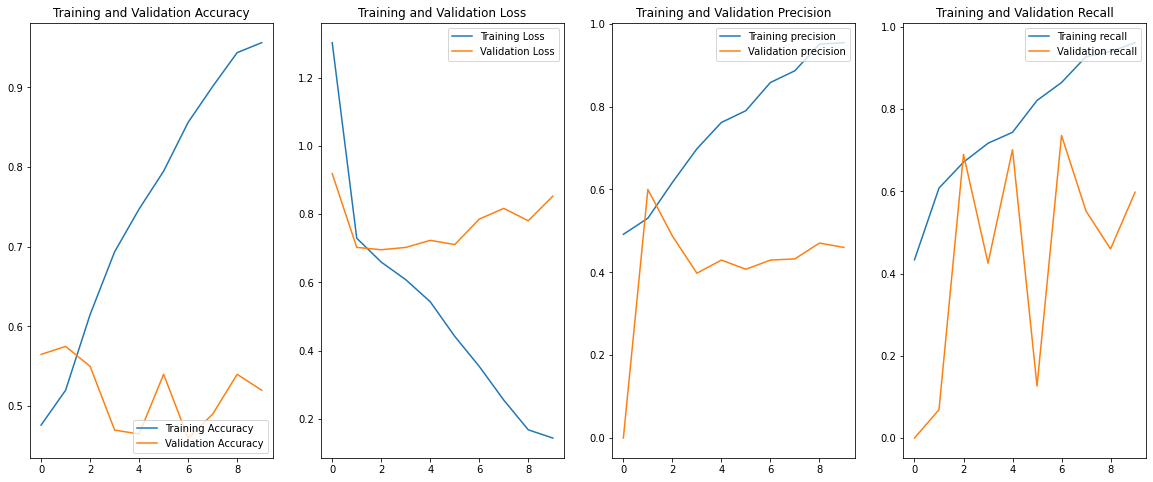

In [ ]:
visualize_results(face_output4)

### Adding a batch normalization layer resulted in the greatest increase in validations, with a precision of 95.43% and recall pf 96.13%

# valid and same paddings

In [ ]:
epochs_=10
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3), padding='same', activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output5 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 28s 908ms/step - loss: 94.5405 - accuracy: 0.4787 - precision_1: 0.4912 - recall_1: 0.2712 - val_loss: 0.6923 - val_accuracy: 0.5550 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 24s 869ms/step - loss: 0.6986 - accuracy: 0.4863 - precision_1: 0.5147 - recall_1: 0.0847 - val_loss: 0.6929 - val_accuracy: 0.5650 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 24s 878ms/step - loss: 0.6910 - accuracy: 0.5275 - precision_1: 0.5239 - recall_1: 0.9298 - val_loss: 1.1242 - val_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 4/10
25/25 [==============================] - 24s 861ms/step - loss: 0.7153 - accuracy: 0.5288 - precision_1: 0.5229 - recall_1: 0.9952 - val_loss: 0.6955 - val_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 5/10
25/25 [==============================] -

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["accuracy"]
  valid_accuracy = face_output.history["val_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision_1"]
  valid_precision = face_output.history["val_precision_1"]

  recall = face_output.history["recall_1"]
  valid_recall = face_output.history["val_recall_1"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}

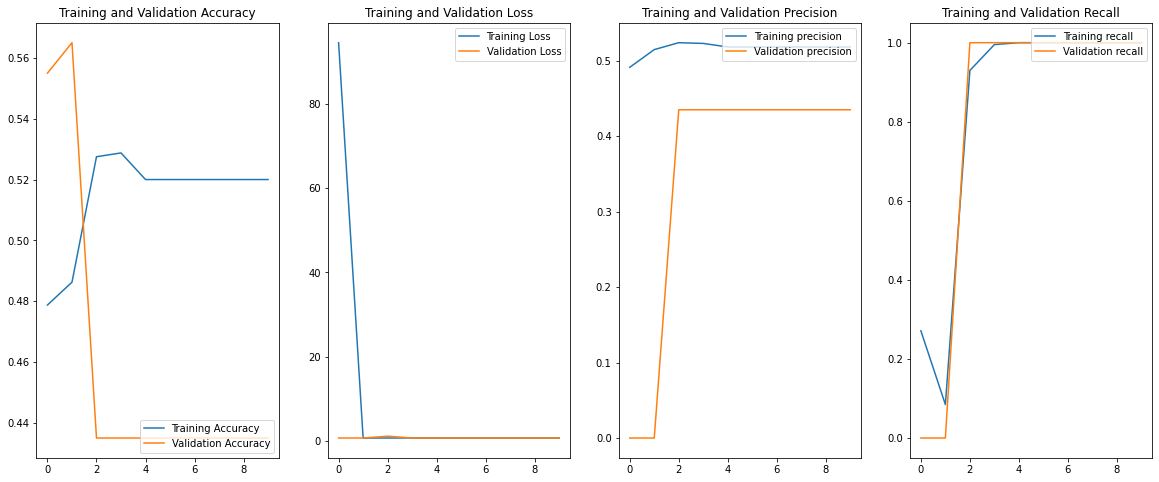

In [ ]:
visualize_results(face_output5)

### Changing to same padding had a minor increase in precision and no change in recall.

# increase number of filters

In [ ]:
epochs_=10
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3),  activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output6 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 27s 922ms/step - loss: 135.3821 - binary_accuracy: 0.5163 - precision_2: 0.5207 - recall_2: 0.7918 - val_loss: 0.6986 - val_binary_accuracy: 0.4400 - val_precision_2: 0.4372 - val_recall_2: 1.0000
Epoch 2/10
25/25 [==============================] - 25s 900ms/step - loss: 0.6919 - binary_accuracy: 0.5175 - precision_2: 0.5171 - recall_2: 0.9903 - val_loss: 0.6984 - val_binary_accuracy: 0.4400 - val_precision_2: 0.4372 - val_recall_2: 1.0000
Epoch 3/10
25/25 [==============================] - 25s 902ms/step - loss: 0.6828 - binary_accuracy: 0.5412 - precision_2: 0.5295 - recall_2: 1.0000 - val_loss: 0.6973 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4343 - val_recall_2: 0.9885
Epoch 4/10
25/25 [==============================] - 24s 894ms/step - loss: 0.6726 - binary_accuracy: 0.5788 - precision_2: 0.5512 - recall_2: 0.9903 - val_loss: 0.7547 - val_binary_accuracy: 0.4950 - val_precision_2: 0.4593 - val_recall_2: 0.9080
Epoch 5/10

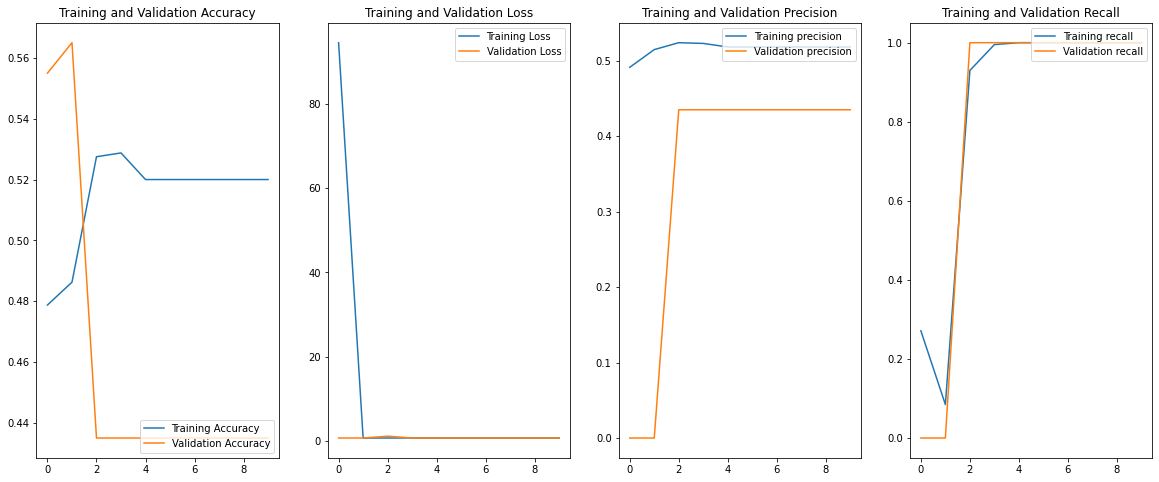

In [ ]:
visualize_results(face_output5)

### Increasing the number of filters had a sharp increase in precision, shooting it up to 90.97%, but there was no change in the recall

# use different pooling sizes? (Use 1 C+P and total 2 filter sizes only)

## using pool size 3

In [ ]:
epochs_=10
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=64, kernel_size =(3, 3), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(3, 3)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output7 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 29s 938ms/step - loss: 69.4913 - binary_accuracy: 0.4988 - precision_1: 0.5138 - recall_1: 0.5400 - val_loss: 0.6983 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 2/10
25/25 [==============================] - 25s 899ms/step - loss: 0.6938 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 1.0000 - val_loss: 0.6961 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 3/10
25/25 [==============================] - 24s 896ms/step - loss: 0.6926 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 1.0000 - val_loss: 0.6988 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 4/10
25/25 [==============================] - 24s 893ms/step - loss: 0.6927 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 1.0000 - val_loss: 0.6986 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 5/10


In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision_1"]
  valid_precision = face_output.history["val_precision_1"]

  recall = face_output.history["recall_1"]
  valid_recall = face_output.history["val_recall_1"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}

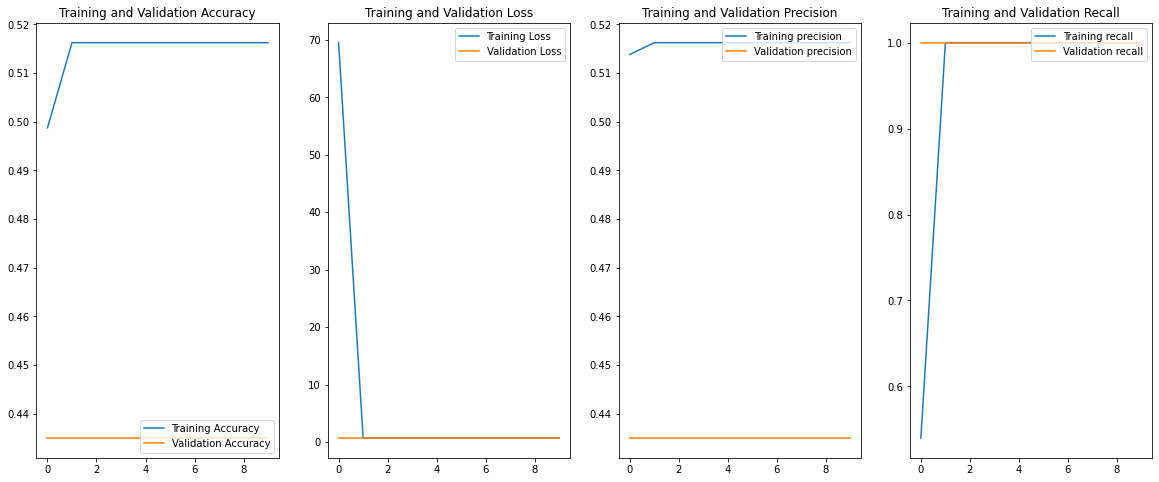

In [ ]:
visualize_results(face_output7)

### Pool size of 3 produced no change in the precision and recall.

## using pool size 4

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=64, kernel_size =(3, 3), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(4, 4)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output7 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 21s 709ms/step - loss: 112.8098 - binary_accuracy: 0.4638 - precision_2: 0.4579 - recall_2: 0.2107 - val_loss: 0.6920 - val_binary_accuracy: 0.5650 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 19s 692ms/step - loss: 0.6930 - binary_accuracy: 0.4975 - precision_2: 0.5433 - recall_2: 0.1671 - val_loss: 0.6945 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4350 - val_recall_2: 1.0000
Epoch 3/10
25/25 [==============================] - 20s 694ms/step - loss: 0.6926 - binary_accuracy: 0.5175 - precision_2: 0.5169 - recall_2: 1.0000 - val_loss: 0.6976 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4350 - val_recall_2: 1.0000
Epoch 4/10
25/25 [==============================] - 19s 690ms/step - loss: 0.6926 - binary_accuracy: 0.5175 - precision_2: 0.5169 - recall_2: 1.0000 - val_loss: 0.6966 - val_binary_accuracy: 0.4350 - val_precision_2: 0.4350 - val_recall_2: 1.0000
Ep

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision_2"]
  valid_precision = face_output.history["val_precision_2"]

  recall = face_output.history["recall_2"]
  valid_recall = face_output.history["val_recall_2"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}

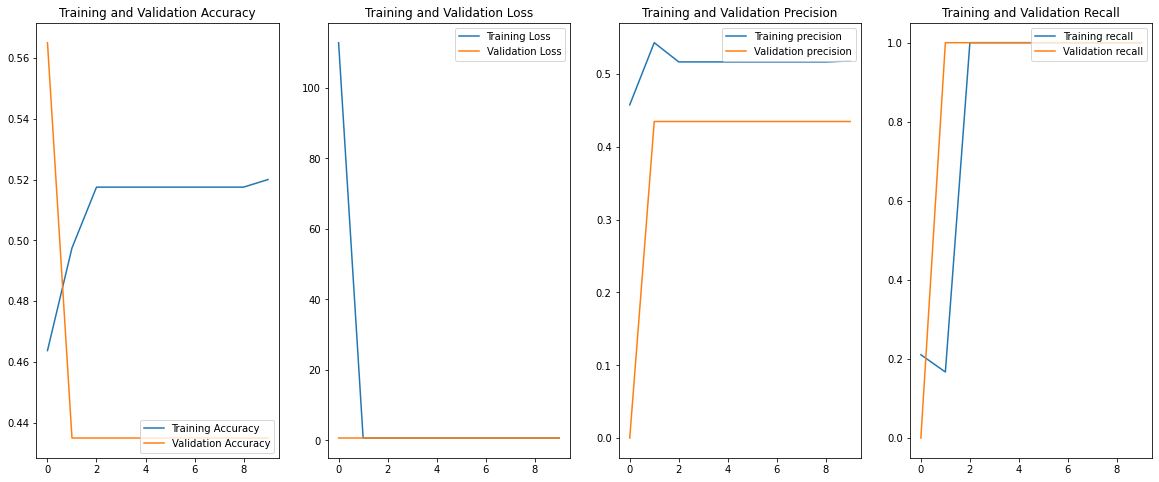

In [ ]:
visualize_results(face_output7)

### Increasing the pool size to 4 had a very minor increase in the precision, and no change in recall.

# use ReLU or Leaky Relu

In [ ]:
epochs_=10
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=32, kernel_size =(3, 3), input_shape=(600,600,3)))
cnn_model.add(layers.LeakyReLU())
cnn_model.add(layers.MaxPooling2D(pool_size=(4, 4)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64))
cnn_model.add(layers.LeakyReLU())
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output8 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 20s 551ms/step - loss: 331.6725 - binary_accuracy: 0.4675 - precision: 0.4855 - recall: 0.5254 - val_loss: 20.7379 - val_binary_accuracy: 0.4900 - val_precision: 0.4299 - val_recall: 0.5287
Epoch 2/10
25/25 [==============================] - 15s 507ms/step - loss: 32.0312 - binary_accuracy: 0.5188 - precision: 0.5354 - recall: 0.5133 - val_loss: 18.7728 - val_binary_accuracy: 0.4300 - val_precision: 0.4270 - val_recall: 0.9080
Epoch 3/10
25/25 [==============================] - 15s 508ms/step - loss: 16.8564 - binary_accuracy: 0.5412 - precision: 0.5525 - recall: 0.5860 - val_loss: 6.8493 - val_binary_accuracy: 0.5550 - val_precision: 0.4706 - val_recall: 0.1839
Epoch 4/10
25/25 [==============================] - 15s 506ms/step - loss: 5.9574 - binary_accuracy: 0.5525 - precision: 0.5726 - recall: 0.5254 - val_loss: 2.6603 - val_binary_accuracy: 0.4650 - val_precision: 0.3958 - val_recall: 0.4368
Epoch 5/10
25/25 [====================

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision"]
  valid_precision = face_output.history["val_precision"]

  recall = face_output.history["recall"]
  valid_recall = face_output.history["val_recall"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}

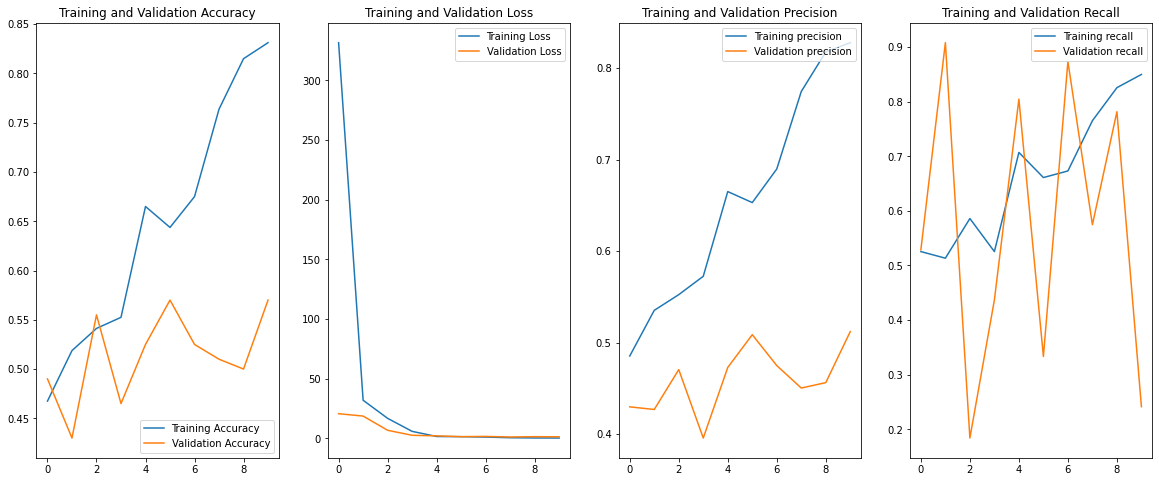

In [ ]:
visualize_results(face_output8)

### Using leaky ReLu layer resulted in a spike in the results, with precision of 82.78% and recall of 84.99%

# change stride from 1 to 2

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
cnn_model.add(layers.Conv2D(filters=64, kernel_size =(3, 3),  strides=(2, 2), activation='relu', input_shape=(600,600,3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(4, 4)))  
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1,  activation='sigmoid'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
face_output8 = cnn_model.fit(train_data,epochs = epochs_, validation_data=(valid_data))

Epoch 1/10
25/25 [==============================] - 14s 432ms/step - loss: 43.6353 - binary_accuracy: 0.4613 - precision_1: 0.4563 - recall_1: 0.2276 - val_loss: 0.6916 - val_binary_accuracy: 0.5650 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 12s 406ms/step - loss: 0.6927 - binary_accuracy: 0.5050 - precision_1: 0.5528 - recall_1: 0.2155 - val_loss: 0.6957 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 3/10
25/25 [==============================] - 12s 403ms/step - loss: 0.6927 - binary_accuracy: 0.5163 - precision_1: 0.5163 - recall_1: 0.9976 - val_loss: 0.7001 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epoch 4/10
25/25 [==============================] - 12s 407ms/step - loss: 0.6927 - binary_accuracy: 0.5175 - precision_1: 0.5169 - recall_1: 0.9976 - val_loss: 0.6958 - val_binary_accuracy: 0.4350 - val_precision_1: 0.4350 - val_recall_1: 1.0000
Epo

In [ ]:
def gather_results(face_output):
  accuracy = face_output.history["binary_accuracy"]
  valid_accuracy = face_output.history["val_binary_accuracy"]

  loss = face_output.history["loss"]
  valid_loss = face_output.history["val_loss"]

  precision = face_output.history["precision_1"]
  valid_precision = face_output.history["val_precision_1"]

  recall = face_output.history["recall_1"]
  valid_recall = face_output.history["val_recall_1"]
  return {"accuracy" :  (accuracy, valid_accuracy),
          "loss" :      (loss, valid_loss),
          "precision" : (precision, valid_precision),
          "recall" :    (recall, valid_recall)}

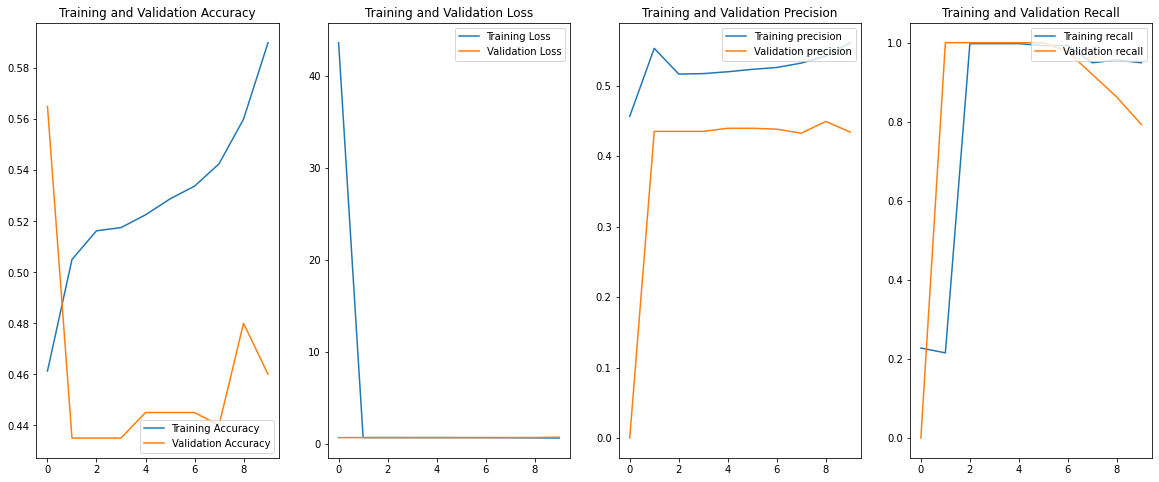

In [ ]:
visualize_results(face_output8)

### Changing the stride from 1 to 2 had a small but noticeable increase in precision to 56.08% and a sharp increase in recall to 94.92%